# Image Classification (Cats vs Dogs)
**Author:** *Mahdi Rafati (mehdirt)*

----

## Libraries

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from utils.train import train_model
from utils.data_utils import *
from utils.model_utils import *
from utils.predict_utils import *
from utils.vis_utils import *

# Some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [8]:
if torch.cuda.is_available():
    device = "cuda"  # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps"  # Use Apple Silicon GPU (if available)
else:
    device = "cpu"  # Default to CPU if no GPU is available
    
device

'mps'

## Data

In [13]:
DATA_DIR = "data/"
os.listdir(DATA_DIR)

['train', 'test', 'val']

In [14]:
trn_dir = f"{DATA_DIR}train"
val_dir = f"{DATA_DIR}val"
test_dir = f"{DATA_DIR}test"

os.listdir(trn_dir)

['non-emergency', 'emergency']

In [15]:
trn_fnames = glob.glob(f"{trn_dir}/*/*.jpg")
trn_fnames[:5]

['data/train/non-emergency/2062.jpg',
 'data/train/non-emergency/0_original_1449.jpg_08324d2b-9ee0-4261-97b3-1a8ff33119b1.jpg',
 'data/train/non-emergency/1242.jpg',
 'data/train/non-emergency/0_original_1643.jpg_073e8156-eb8b-430c-8f9b-df81b57fc456.jpg',
 'data/train/non-emergency/0_original_1705.jpg_7da33711-1e3d-4a27-9709-ff08fb72f2e5.jpg']

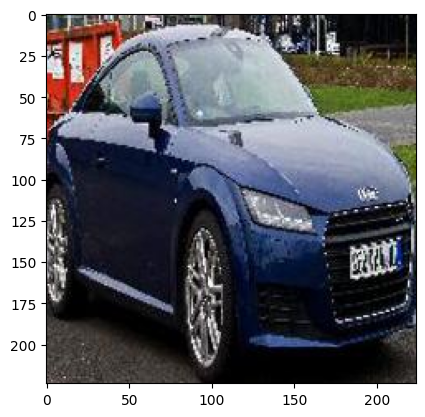

In [16]:
img = plt.imread(trn_fnames[15])
plt.imshow(img)

## Datasets and DataLoaders in Pytorch

In [17]:
train_ds = datasets.ImageFolder(trn_dir)
train_ds.classes

['emergency', 'non-emergency']

In [18]:
print(train_ds.class_to_idx, train_ds.root, sep='\n')

{'emergency': 0, 'non-emergency': 1}
data/train


In [19]:
train_ds.imgs[:10]

[('data/train/emergency/1000672.jpg', 0),
 ('data/train/emergency/110.jpg', 0),
 ('data/train/emergency/133.jpg', 0),
 ('data/train/emergency/141412.jpg', 0),
 ('data/train/emergency/151.jpg', 0),
 ('data/train/emergency/156363782.jpg', 0),
 ('data/train/emergency/1627345419.jpg', 0),
 ('data/train/emergency/17.jpg', 0),
 ('data/train/emergency/171.jpg', 0),
 ('data/train/emergency/197.jpg', 0)]

In [20]:
type(train_ds.transform)

NoneType

### Transformations

DataLoader object uses these transformations when loading data:

In [21]:
size = 224
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
tfms = transforms.Compose([
    transforms.Resize((size, size)), # PIL Image
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)
test_ds = datasets.ImageFolder(test_dir, transform=tfms)

In [23]:
len(train_ds), len(valid_ds), len(test_ds)

(4657, 330, 706)

### DataLoaders

In [24]:
train_dl = DataLoader(train_ds,
                     batch_size=batch_size,
                     shuffle=True,
                     num_workers=4)

valid_dl = DataLoader(valid_ds,
                     batch_size=batch_size,
                     shuffle=False,
                     num_workers=4)

test_dl = DataLoader(test_ds,
                     batch_size=batch_size,
                     shuffle=False,
                     num_workers=4)

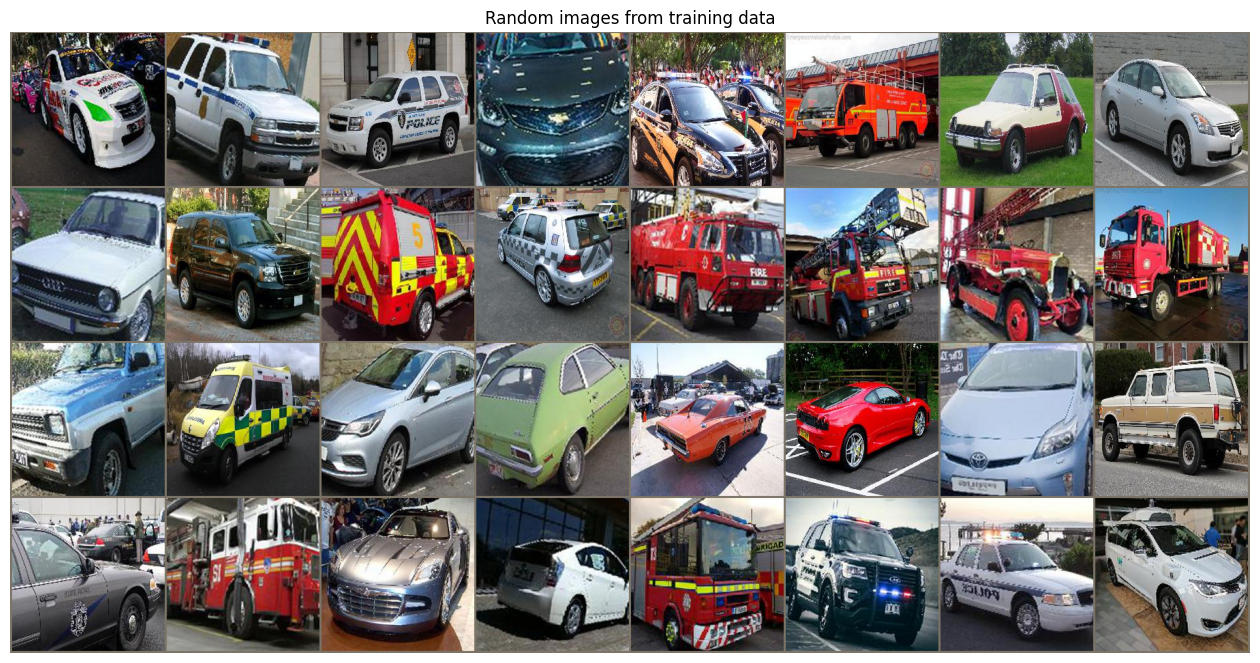

In [25]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title="Random images from training data")

## Transfer Learning

- Use a CNN already trained on different data (e.g. ImageNet)

- Just train the classifier weights (Last layer)

In [26]:
# Load pre-trained ResNet34
model = load_pretrained_resnet18(model_path=None, num_classes=15)
model = model.to(device)

/home/mahdirt/miniconda3/envs/cvision/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mahdirt/miniconda3/envs/cvision/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Loss Function and Optimizer

In [29]:
# loss and optmizer
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [30]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=num_epochs)

Epoch 1/10
----------
  train Loss: 0.21475 Acc: 0.91518
  valid Loss: 0.14346 Acc: 0.95455

Epoch 2/10
----------
  train Loss: 0.05222 Acc: 0.98304
  valid Loss: 0.18289 Acc: 0.95455

Epoch 3/10
----------
  train Loss: 0.01892 Acc: 0.99506
  valid Loss: 0.19433 Acc: 0.95152

Epoch 4/10
----------
  train Loss: 0.00810 Acc: 0.99850
  valid Loss: 0.20111 Acc: 0.95152

Epoch 5/10
----------
  train Loss: 0.00668 Acc: 0.99828
  valid Loss: 0.20826 Acc: 0.95152

Epoch 6/10
----------
  train Loss: 0.00557 Acc: 0.99850
  valid Loss: 0.22263 Acc: 0.94545

Epoch 7/10
----------
  train Loss: 0.00628 Acc: 0.99828
  valid Loss: 0.22183 Acc: 0.94848

Epoch 8/10
----------
  train Loss: 0.00662 Acc: 0.99850
  valid Loss: 0.23762 Acc: 0.94242

Epoch 9/10
----------
  train Loss: 0.00320 Acc: 0.99893
  valid Loss: 0.22447 Acc: 0.95455

Epoch 10/10
----------
  train Loss: 0.00521 Acc: 0.99807
  valid Loss: 0.24695 Acc: 0.93939

Training complete in 261m 21s
Best val Acc: 0.9545


## Load the Best trained model

In [37]:
model_path = "models/epoch-0-acc-0.95455.pth"
# Load the model with trained weights
model = load_trained_resnet18(model_path=model_path, num_classes=15, use_gpu=(device == "cuda"))
model = model.to(device)

/home/mahdirt/miniconda3/envs/cvision/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mahdirt/miniconda3/envs/cvision/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weights loaded successfully!


## Analyze Results

In [38]:
def evaluate_model(model, dataloader, device):
    model.eval() 
    corrects = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()

    print(f"Accuracy: {100 * corrects / len(dataloader.dataset):.2f}")

### Accuracy on Validation Data

In [39]:
evaluate_model(model, valid_dl, device)

Accuracy: 95.45


### Accuracy on Test Data

In [40]:
evaluate_model(model, test_dl, device)

Accuracy: 94.62


### Accuracy on Training Data

In [41]:
evaluate_model(model, train_dl, device)

Accuracy: 98.90


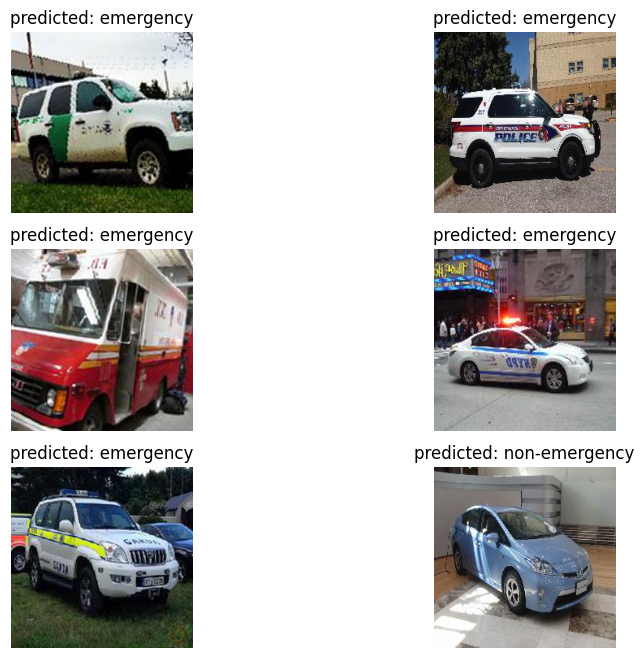

In [42]:
visualize_model(model, train_dl, device)

100%|██████████| 11/11 [00:42<00:00,  3.89s/it]


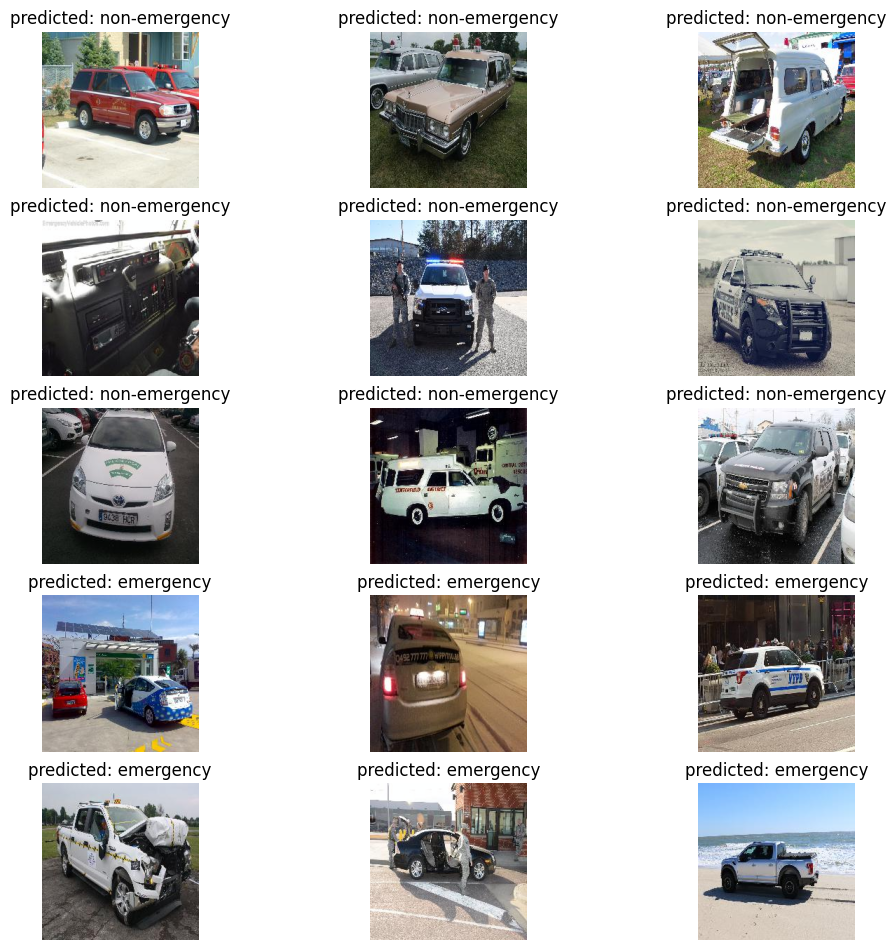

15 images out of 330 were misclassified.


In [43]:
plot_errors(model, valid_dl, device)

### Confusion Matrix

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:44<00:00,  4.04s/it]


[[0.95 0.05]
 [0.04 0.96]]


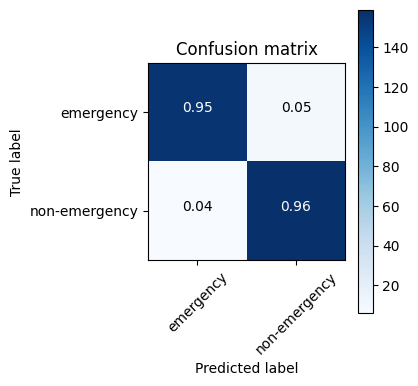

In [44]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Export the model to ONXX format

In [45]:
# Create a random input (adjust shape to your model's input size)
random_input = torch.randn(1, 3, 224, 224)  # (batch_size, channels, height, width)

# Export to ONNX
torch.onnx.export(
    model,                              # PyTorch model
    random_input,                       # Input tensor
    "models/emergency_detector.onnx",     # Output file path (directly save here)
    input_names=["input"],              # Input tensor name
    output_names=["output"],            # Output tensor name
    opset_version=12                    # ONNX operator set version
)

print("Model successfully exported to models/emergency_detector.onnx")

Model successfully exported to models/emergency_detector.onnx


### Check ONNX model 

In [47]:
import onnx

onnx_model = onnx.load("models/emergency_detector.onnx")
onnx.checker.check_model(onnx_model)

## Overfit

In case that the model is still overfitting, we turn to data augmentation.

### Data Augmentation

In [ ]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{DATA_DIR}train", train_transforms)
valid_ds = datasets.ImageFolder(f"{DATA_DIR}valid", valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=4)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print(f"Train size: {train_ds_sz}\n Valid size: {valid_ds_sz} ({valid_ds_sz / (train_ds_sz + valid_ds_sz):.2f})")

class_names = train_ds.classes 

NameError: name 'transforms' is not defined

In [ ]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title="Augmented Images")

NameError: name 'train_dl' is not defined

### Look at the sizes of images

In [7]:
fnames = glob.glob(f"{trn_dir}/*/*.jpg")
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12, 4))
plt.hist(hs, label="Hights", color='blue')
plt.hist(ws, label="Widths", color='orange')

NameError: name 'glob' is not defined